In [17]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import utilssphering
import utils
import os
import random
import numpy as np
import itertools
import pycytominer
import matplotlib.pyplot as plt
import ast

random.seed(9000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib 
# Get versions of stuff, if you want
print(
    pd.__version__,
    np.version.version,
    matplotlib.__version__
)

1.4.2 1.22.4 3.5.2


In [3]:
# Set some variables + read the metadata

n_samples = 1000
n_replicates = 4  #number of sample replicates within each plate 
metadata_common = 'Metadata_moa'
metadata_perturbation = 'Metadata_broad_sample'
group_by_feature = 'Metadata_broad_sample'

experiment_df = (
    pd.read_csv('output/experiment-metadata-updated.csv')
)

experiment_df

,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,spinning-disc,Binning,Magnification,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,Number_of_channels,Images_per_well,z_plane,BF_Zplanes,Anomaly
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,no,1,10,0.45,NaN,NaN,NaN,6,4,1,NaN,none
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,yes,1,10,0.45,NaN,NaN,NaN,6,4,1,NaN,none
2,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,yes,1,10,0.45,NaN,NaN,NaN,6,4,3,NaN,none
3,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,yes,1,20,0.75,NaN,NaN,NaN,6,4,3,NaN,none
4,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,no,1,20,0.75,NaN,NaN,NaN,6,9,1,NaN,none
5,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_9site_20XPA_Crest,Confocal,yes,1,20,0.75,NaN,NaN,NaN,6,9,1,NaN,none
6,MolDev,Scope1_MolDev_20X_Adaptive,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_Adaptive_20XPA,Confocal,yes,1,20,0.75,NaN,NaN,NaN,6,3,1,NaN,none
7,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,NaN,1,10,0.45,NaN,NaN,NaN,4,1,1,NaN,none
8,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,NaN,1,10,0.45,NaN,NaN,NaN,4,1,1,NaN,none
9,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117062a10x,Widefield,NaN,1,10,0.45,NaN,NaN,NaN,4,1,1,NaN,none


In [30]:
# List columns, if you'd like

dire = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA"

for i in os.listdir(dire):
    if i.endswith(".csv.gz"):
        print(i)
        t = pd.read_csv(os.path.join("../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA", i))
        # pd.read_csv("../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz")
        print([i for i in t.columns if "Metadata" in i])

# test = pd.read_csv("../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA.csv.gz")

# [i for i in plate_df.columns if "metadata_" in i.casefold()]

# test

Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz
['Metadata_broad_sample', 'Metadata_solvent', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Site_Count', 'Metadata_Count_Cells', 'Metadata_Count_CellsSmall', 'Metadata_Count_Cytoplasm', 'Metadata_Count_CytoplasmSmall', 'Metadata_Count_Nuclei', 'Metadata_Count_NucleiSmall', 'Metadata_Object_Count', 'Metadata_InChIKey', 'Metadata_pert_iname', 'Metadata_pubchem_cid', 'Metadata_moa', 'Metadata_pert_type', 'Metadata_control_type', 'Metadata_smiles']
Plate2_PCO_6ch_4site_10XPA.csv.gz
['Metadata_Plate', 'Metadata_Well', 'Metadata_Site_Count', 'Metadata_Count_Cells', 'Metadata_Count_CellsSmall', 'Metadata_Count_Cytoplasm', 'Metadata_Count_CytoplasmSmall', 'Metadata_Count_Nuclei', 'Metadata_Count_NucleiSmall', 'Metadata_Object_Count']
Plate2_PCO_6ch_4site_10XPA_normalized.csv.gz
['Metadata_broad_sample', 'Metadata_solvent', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Site_Count', 'Metadata_Count_Cells', 'Metadata_Count_CellsSmall', 'Metadata_C

In [4]:
def create_moa_dataframe(experiment_metadata, profile_parent_dir, batch_col="Batch", match_or_rep_or_both="replicating", enable_sphering="both"):
    """
    batch_col is the name of the column to distinguish the profile parent folder. Eg. "Scope1_MolDev_10X" or "1siteSubSample_Scope1_MolDev_10X"
    Output df will also use this batch_col name
    """
    n_samples = 1000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_broad_sample'

    corr_replicating_list = list()
    corr_matching_list = list()

    for ind, a_vendor in enumerate(experiment_metadata["Vendor"].unique()):
        vendor_data = experiment_metadata.loc[experiment_metadata["Vendor"] == a_vendor]
        for a_batch in vendor_data[batch_col].unique():
            batch_data = vendor_data.loc[vendor_data[batch_col] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
                load_data = pd.read_csv(data_path)
                if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                    if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                        sphere_bool = True
                        replicate_corr_sphere, null_replicating_sphere, prop_95_replicating_sphere, value_95_replicating_sphere = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)
                        corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Replicating':[replicate_corr_sphere],
                                                                    'Null_Replicating':[null_replicating_sphere],
                                                                    'Percent_Replicating':prop_95_replicating_sphere,
                                                                    'Value_95':value_95_replicating_sphere,
                                                                    'sphering': sphere_bool}, index=[ind]))

                    if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                        sphere_bool = False
                        plate_df = utils.remove_negcon_empty_wells(load_data)
                        replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
                        null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
                        prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicate_corr, how='right')
                        corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Replicating':[replicate_corr],
                                                                    'Null_Replicating':[null_replicating],
                                                                    'Percent_Replicating':prop_95_replicating,
                                                                    'Value_95':value_95_replicating,
                                                                    'sphering': sphere_bool}, index=[ind]))

                if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                    if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                        sphere_bool = True
                        matching_corr_sphere, null_matching_sphere, prop_95_matching_sphere, value_95_matching_sphere = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)
                        corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                batch_col: a_batch,
                                                                'Assay_Plate_Barcode': a_plate,
                                                                'Matching':[matching_corr_sphere],
                                                                'Null_Matching':[null_matching_sphere],
                                                                'Percent_Matching':prop_95_matching_sphere,
                                                                'Value_95':value_95_matching_sphere,
                                                                'sphering': sphere_bool}, index=[ind]))
                    
                    if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                        sphere_bool = False
                        plate_df = utils.remove_negcon_empty_wells(load_data)
                        matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
                        null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
                        prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')
                        corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                batch_col: a_batch,
                                                                'Assay_Plate_Barcode': a_plate,
                                                                'Matching':[matching_corr],
                                                                'Null_Matching':[null_matching],
                                                                'Percent_Matching':prop_95_matching,
                                                                'Value_95':value_95_matching,
                                                                'sphering': sphere_bool}, index=[ind]))
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = pd.concat(corr_replicating_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        corr_matching_df = pd.concat(corr_matching_list, ignore_index=True)
                
    # Merge metadata with output dataframes
    merge_columns = ['Vendor', batch_col, 'Assay_Plate_Barcode']
    if match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
        corr_matching_df = experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)
        return corr_replicating_df, corr_matching_df
    if match_or_rep_or_both.casefold() == "replicating":
        return experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
    elif match_or_rep_or_both.casefold() == "matching":
        return experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)

df_replicating, df_matching = create_moa_dataframe(experiment_df, "../jump-scope/profiles/", match_or_rep_or_both="both", enable_sphering="both")
# df = create_moa_dataframe(pd.read_csv('output/experiment-metadata.tsv', sep='\t'), "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="no")

# df


SyntaxError: unexpected EOF while parsing (2590682113.py, line 98)

In [266]:
## Checkpoint save

if not os.path.isdir("checkpoints"):
    os.mkdir("checkpoints")

df_replicating.to_csv("checkpoints/moa-replicating-sphering.csv", index_label='index', index=False)

df_matching.to_csv("checkpoints/moa-matching-sphering.csv", index_label='index', index=False)

In [ ]:
# Load checkpoints

df_replicating = pd.read_csv("checkpoints/moa-replicating-sphering.csv", converters={'Null_Replicating':utilssphering.safe_literal_eval, "Replicating":utilssphering.safe_literal_eval}, na_values=np.nan)
df_matching = pd.read_csv("checkpoints/moa-matching-sphering.csv", converters={'Null_Matching':utilssphering.safe_literal_eval, "Matching":utilssphering.safe_literal_eval})

# print(len(df_matching.loc[0, ["Null_Matching"]][0]), len(df_replicating.loc[0, ["Null_Replicating"]][0]))
# print(len(df_matching1.loc[0, ["Null_Matching"]][0]), len(df_replicating1.loc[0, ["Null_Replicating"]][0]))


In [ ]:
def dumbell_plot(df, save_fig=False):

        fig, ax = plt.subplots(figsize=(5, 20), dpi=200)

        df_len = df[df["sphering"]==True].shape[0]

        ax.set_xlim([10, 85])
        ax.hlines(df[df["sphering"]==True]["Assay_Plate_Barcode"], 
                xmin=df[df["sphering"]==False]["Percent_Replicating"].astype(float), 
                xmax=df[df["sphering"]==True]["Percent_Replicating"].astype(float),
                color='grey', alpha=0.4)
        ax.scatter(df[df["sphering"]==False]["Percent_Replicating"].astype(float),
                df[df["sphering"]==False]["Assay_Plate_Barcode"],
                color='skyblue', alpha=1,
                label="No Sphere")
        ax.scatter(df[df["sphering"]==True]["Percent_Replicating"].astype(float),
                df[df["sphering"]==True]["Assay_Plate_Barcode"],
                color='green', alpha=0.4,
                label="Sphere")
                # Sort=False to maintain order used in ax.hlines
        for (_, row), y in zip(df.groupby("Assay_Plate_Barcode", sort=False), range(0, df_len+1)):
                row.loc[row["sphering"]==True]["Percent_Replicating"].iloc[0]
                difference_value = row.loc[row['sphering']==True]['Percent_Replicating'].iloc[0] - row.loc[row['sphering']==False]['Percent_Replicating'].iloc[0]
                plt.annotate(f"+{difference_value:.1f}%", (row.loc[row["sphering"]==True]["Percent_Replicating"].iloc[0]+2, y -0.2))

        ax.legend(ncol=2, bbox_to_anchor=(1, 1.001), loc="lower right", frameon=False)
        fig.set_facecolor("white")

        if save_fig:
                fig.savefig("have_no_sphere.png", bbox_inches = 'tight')

dumbell_plot(df_replicating)

In [323]:
# Hide code output plots
%%capture 

# Recreate distribution plots
def distribution_plots(df, save_fig=False, outfile=None):

    n_experiments = df.shape[0]

    fig, ax_ = plt.subplots(n_experiments, 1, figsize=[12, n_experiments*8])
    for i, ax in zip(df.index, ax_.flatten()):
        ax.hist(df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
        ax.hist(df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
        ax.axvline(df.loc[i,'Value_95'], label='95% threshold')
        ax.legend(fontsize=20)
        ax.set_title(
            f"{df.loc[i,'Vendor']}\n" +
            f"Batch = {df.loc[i, 'Batch']}\n" +
            f"Plate = {df.loc[i, 'Assay_Plate_Barcode']}\n" +
            f"Percent Replicating = {df.loc[i,'Percent_Replicating']}",
            fontsize=25
        )
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("Density", fontsize=25)
        ax.set_xlabel("Replicate correlation", fontsize=25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.tight_layout()

    if save_fig:
        if outfile is not None:
            print(f"Saving figure to: {outfile}")
            fig.savefig(f"{outfile}", bbox_inches = 'tight')
        else:
            print("Saving figure to: distribution-plot.png")
            fig.savefig("distribution-plot.png", bbox_inches = "tight")
    return fig

distribution_plots(df_replicating.loc[df_replicating["sphering"]==True], save_fig=True, outfile="figures/distribution-with-sphering.png")
distribution_plots(df_replicating.loc[df_replicating["sphering"]==False], save_fig=True, outfile="figures/distribution-no-sphering.png")


In [325]:
# Trying to find method to find assay_plate_barcodes with os.walk

_, parent_folders, _ = next(os.walk("../jump-scope/profiles/"))

batchname_list = []
for i in parent_folders:
    _, subdirs, _ = next(os.walk(f"../jump-scope/profiles/{i}"))
    batchname_list.extend([os.path.join(f"../jump-scope/profiles/{i}/{sub}") for sub in subdirs])
# Why set? Well, it seems that there are profile duplicates within parent_folders
# I assume the original grouping was determined at this point, rather than through 
# reference to some central grouping DataFrame
# print(len(set(batchname_list)))

# print(batchname_list)

unique_batch_names = []
unique_batch_paths = []
for batch_path in batchname_list:
    batch_name = batch_path.split(os.path.sep)[-1]
    if batch_name not in unique_batch_names:
        unique_batch_names.append(batch_name)
        unique_batch_paths.append(batch_path)

print(len(unique_batch_paths))
# print(unique_batch_paths)

# batchname_list[0].split(os.path.sep)[-1]

56


# FoV and cell count analysis using the *siteSubSample* profiles

In [67]:
fov_experiment_df = (
    pd.read_csv('output/FoV-experiment-metadata.tsv', sep='\t')
#    .query('Batch==@batch')
)

fov_experiment_df

,Vendor,Batch,FoV_Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,Unnamed: 11,z_plane,BF_Zplanes,Anomaly
0,MolDev,Scope1_MolDev_10X,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1,1,10,6,NaN,1,NaN,none
1,MolDev,Scope1_MolDev_10X,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1,1,10,6,NaN,1,NaN,none
2,MolDev,Scope1_MolDev_10X_4siteZ,1siteSubSample_Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,1,1,10,6,NaN,1,NaN,none
3,MolDev,Scope1_MolDev_20X_4site,1siteSubSample_Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,1,1,20,6,NaN,1,NaN,none
4,MolDev,Scope1_MolDev_20X_9site,1siteSubSample_Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,1,1,20,6,NaN,1,NaN,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4,1,20,5,NaN,12,13,none
124,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4,1,20,5,NaN,12,15,none
125,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4,1,20,6,NaN,12,15,none
126,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4,1,20,6,NaN,12,15,none


In [68]:
# Add perc rep/match to FoV

fov_df_replicating = create_moa_dataframe(pd.read_csv('output/FoV-experiment-metadata.tsv', sep='\t'), 
                                                    "../jump-scope/profiles/",
                                                    batch_col="FoV_Batch",
                                                     match_or_rep_or_both="replicating", 
                                                     enable_sphering="no")

# fov_df_matching = create_moa_dataframe(pd.read_csv('output/FoV-experiment-metadata.tsv', sep='\t'), 
#                                                     "../jump-scope/profiles/",
#                                                     batch_col="FoV_Batch",
#                                                      match_or_rep_or_both="matching", 
#                                                      enable_sphering="no")

# fov_df_replicating = create_moa_dataframe(pd.read_csv('output/FoV-experiment-metadata.tsv', sep='\t'), 
#                                                     "../jump-scope/profiles/",
#                                                     batch_col="FoV_Batch",
#                                                      match_or_rep_or_both="replicating", 
#                                                      enable_sphering="yes")

def add_total_cell_counts(df, profile_path):
    out_df = df.copy()
    for i in df.index:
        batch = df.loc[i, "FoV_Batch"]
        barcode = df.loc[i, "Assay_Plate_Barcode"]
        load_path = os.path.join(profile_path, batch, barcode, f"{barcode}_normalized_negcon.csv.gz")
        load_df = pd.read_csv(load_path)
        sum_cells = sum(load_df.loc[:,"Metadata_Count_Cells"])
        out_df.loc[i, "Cell_Count"] = sum_cells
    return out_df

fov_df_replicating = add_total_cell_counts(fov_df_replicating, "../jump-scope/profiles/")

fov_df_replicating
# fov_df_matching


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,Vendor,Batch,FoV_Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,...,Unnamed: 11,z_plane,BF_Zplanes,Anomaly,Replicating,Null_Replicating,Percent_Replicating,Value_95,sphering,Cell_Count
0,MolDev,Scope1_MolDev_10X,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1,1,10,...,NaN,1,NaN,none,"[-0.0035480679468849917, -0.02713708204376649,...","[0.022376548993896565, 0.00013365390207073643,...",17.777778,0.402206,False,511430.0
1,MolDev,Scope1_MolDev_10X,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1,1,10,...,NaN,1,NaN,none,"[0.02610832466873135, 0.039859624120984205, 0....","[0.15532973213491028, 0.019266929234316953, 0....",23.333333,0.488058,False,617546.0
2,MolDev,Scope1_MolDev_10X_4siteZ,1siteSubSample_Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,1,1,10,...,NaN,1,NaN,none,"[-0.013443456762634672, -0.015926390000716273,...","[0.25989550211598567, 0.5990168219673834, -0.0...",20.000000,0.671042,False,608864.0
3,MolDev,Scope1_MolDev_20X_4site,1siteSubSample_Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,1,1,20,...,NaN,1,NaN,none,"[-0.06992517003129306, -0.05415402501605597, 0...","[0.23414090102456286, 0.01269786862617996, 0.0...",34.444444,0.324245,False,132155.0
4,MolDev,Scope1_MolDev_20X_9site,1siteSubSample_Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,1,1,20,...,NaN,1,NaN,none,"[0.09293820147883512, -0.027940625654125105, -...","[0.31816509884043176, 0.04113458183217434, 0.0...",24.444444,0.423722,False,137083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4,1,20,...,NaN,12,13,none,"[0.11787495125566441, 0.16802342032189477, 0.2...","[0.34407109311225326, 0.06787589266602236, -0....",41.111111,0.342519,False,544244.0
124,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4,1,20,...,NaN,12,15,none,"[0.16959184770712224, 0.22233273446776852, 0.0...","[-0.018133237398572755, -0.04198256296740488, ...",45.555556,0.323481,False,543826.0
125,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4,1,20,...,NaN,12,15,none,"[0.38973771531652707, 0.01460006207482378, 0.1...","[0.04613611678468739, 0.4294860412641134, 0.06...",20.000000,0.619119,False,489099.0
126,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4,1,20,...,NaN,12,15,none,"[-0.04580911089947984, -0.041760079848138204, ...","[0.12186088341580506, 0.4264830109293543, 0.22...",21.111111,0.668587,False,452567.0


In [18]:
# FoV Checkpoint save

if not os.path.isdir("checkpoints"):
    os.mkdir("checkpoints")

fov_df_replicating.to_csv("checkpoints/fov-moa-replicating-sphering.csv", index_label='index', index=False)
# df_matching.to_csv("checkpoints/fov-moa-matching-sphering.csv", index_label='index', index=False)

In [ ]:
# Load FoV Checkpoint

fov_df_replicating = pd.read_csv("checkpoints/fov-moa-replicating-sphering.csv", converters={'Null_Replicating':utilssphering.safe_literal_eval, "Replicating":utilssphering.safe_literal_eval})
# fov_df_matching = pd.read_csv("checkpoints/fov-moa-matching-sphering.csv", converters={'Null_Matching':utilssphering.safe_literal_eval, "Matching":utilssphering.safe_literal_eval})

In [ ]:
def fov_cell_count_plots(df, save_fig=False, outfile=None):
    n_experiments = len(df)
    fig, ax_ = plt.subplots(n_experiments, 1, figsize=[12, n_experiments*8], facecolor="white")

    for ((_, rows), ax) in zip(df, ax_.flatten()):
        x = rows.loc[:,"Cell_Count"]
        y = rows.loc[:,"Percent_Replicating"]
        ax.scatter(x, y)
        ax.plot(x, y)
        for i, txt in enumerate(range(0, len(x))):
            ax.annotate(rows.loc[:,"Sites-SubSampled"].values[i], 
            (x.values[i], y.values[i]),
            fontsize=25,
            horizontalalignment='center',
            verticalalignment='bottom'
            )

        ax.set_title(
            f"{rows.loc[:,'Vendor'].unique()}\n" +
            f"Batch = {rows.loc[:, 'FoV_Batch'].unique()}\n" +
            f"Plate = {rows.loc[:, 'Assay_Plate_Barcode'].unique()}\n",
            fontsize=25
        )
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel("Percent Replicating", fontsize=25)
        ax.set_xlabel("Number of Cells", fontsize=25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.tight_layout()

    if save_fig:
        if outfile is not None:
            print(f"Saving figure to: {outfile}")
            fig.savefig(f"{outfile}", bbox_inches = 'tight')
        else:
            print("Saving figure to: fov_count_plot.png")
            fig.savefig("fov_count_plot.png", bbox_inches = "tight")
    return fig

fov_cell_count_plots(fov_df_replicating.groupby(["Batch", "Assay_Plate_Barcode"]), save_fig=True, outfile="figures/fov_cell_count.png")


# Dropout plots

In [82]:
### Creating dropout datasets + matrix

def return_prop95(dataframe, match_or_rep="replicating", enable_sphering=False):
    """
    dataframe: pandas.DataFrame to find the prop95 for 
    """
    n_samples = 1000
    n_replicates = 4  #number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    # metadata_perturbation = 'Metadata_broad_sample'
    # group_by_feature = 'Metadata_broad_sample'
    metadata_perturbation = 'Metadata_pert_iname'
    group_by_feature = 'Metadata_pert_iname'
    if match_or_rep.casefold() == "replicating":
        if enable_sphering:
            _, _, prop_95_replicating_sphere, _ = utilssphering.calculate_percent_replicating_MOA("", "", data_df=dataframe)
            return prop_95_replicating_sphere

        if not enable_sphering: 
            plate_df = utils.remove_negcon_empty_wells(dataframe)
            replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
            prop_95_replicating, _ = utils.percent_score(null_replicating, replicate_corr, how='right')
            return prop_95_replicating

    if match_or_rep.casefold() == "matching":
        if enable_sphering:
            _, _, prop_95_matching_sphere, _ = utilssphering.calculate_percent_matching_MOA("", "", data_df=dataframe)
            return prop_95_matching_sphere

        if not enable_sphering:
            plate_df = utils.remove_negcon_empty_wells(dataframe)
            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
            prop_95_matching, _ = utils.percent_score(null_matching, matching_corr, how='right')
            return prop_95_matching


def do_feature_select(plate_df):
    """
    Find the column names that are CellProfiler features. Eg. column names
    that start with "Nuclei" or "Cytoplasm"
    """
    feature_select_features = pycytominer.cyto_utils.infer_cp_features(
        plate_df
    )
    # For all of the cellprofiler features, perform these operations on them
    return pycytominer.feature_select(
        profiles=plate_df,
        features=feature_select_features,
        operation=['variance_threshold','correlation_threshold',
        'drop_na_columns','blocklist']
    )

def all_combo_dropouts_in_a_category(category_list,outfile,subsample=None):
    """
    Create a database with dropped out features

    category_list: the categories to drop out (for example, Nuclei, Cytoplasm, Cells)
    outfile: save csv path
    """
    # For all of the categories, find all possible combinations with itertools.combinations
    to_try = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]

    # If the output csv already exists, check what dropouts have already been tried
    # Don't try them again
    if os.path.exists(outfile):
        dropout_df = pd.read_csv(outfile)
        tried=list(dropout_df['Dropout'])
        print(f"Already try {tried},skipping")
        to_try = [x for x in to_try if str(x) not in tried]
    # Otherwise, dropout columns will be generated from scratch
    else:
        dropout_df = pd.DataFrame()
    
    # For the given categories, go through each combination (eg. ('Cells', 'Cytoplasm'), ('Nuclei', 'Cytoplasm') etc.)
    for eachdropout in to_try:
        # Get what columns are expected. I don't like this method
        normalized_master = pd.read_csv('../profiles-pilots/profiles/Stain5_CondC_Standard/BR00120274/BR00120274_normalized_negcon.csv.gz')
        col_list = normalized_master.columns
        if subsample:
             for each_item in subsample:
                metadata_list = [x for x in col_list if 'Metadata' in x] 
                col_list = metadata_list+[x for x in col_list if each_item in x]
        for each_item in eachdropout:
            # Create a list of columns that DOESN'T contain the categories being iterated
            # Thus this will iterate over all categories (eg. nuclei, cell, cytoplasm) and
            # drop all of the column names
            col_list = [x for x in col_list if each_item not in x]
        dropout_dict = {}
        temp_dropout_dict = {}
        # Code unique to this dataset. Iterate through plates
        for eachplate in range(70,78):
            try:
                # Read only the columns previously defined for each plate being iterated over
                # Again, don't like this hardcoding. Should be some sort of os.walk situation
                normalized = pandas.read_csv(
                    f'../profiles-pilots/profiles/Stain5_CondC_Standard/BR001202{eachplate}/BR001202{eachplate}_normalized_negcon.csv.gz',
                    usecols=col_list)
                # For the loaded dataset, calculate feature selection AFTER column dropout
                feature_select = do_feature_select(normalized)
                temp_dropout_dict[f'{eachplate}_featnum']=len(feature_select.columns)
                # Now, calculate the perc_rep for the dropout dataset 
                ### NOTE: in utilsphering, calculate_percent_replicating_MOA has been updated to return
                ### replicate_corr, null_corr, prop_95, value_95_replicating
                ### In this example, calculate_percent_replicating_MOA is **only returning prop_95**
                dropout_dict[f'BR001202{eachplate}']= calculate_percent_replicating_MOA('','',data_df=feature_select)
            except:
                dropout_dict[f'BR001202{eachplate}']=0
        # Convert the calculated perc_rep into np.array for each dropout 
        results_array = np.array(list(dropout_dict.values()))
        for k,v in temp_dropout_dict.items():
            dropout_dict[k]=v
        # For the dropout dataset created, calculate the mean perc_replicating for ALL of the plates
        # Why all of the plates? Are these replicates?
        # Means are calculated within each dropout group
        dropout_dict['Mean']=results_array.mean()
        dropout_dict['Median']=np.median(results_array)
        dropout_dict['Standard deviation']=np.std(results_array)
        dropout_dict['Dropout']=eachdropout
        dropout_dict['Remaining'] = [x for x in category_list if x not in eachdropout]
        dropout_dict['n_columns']=len(col_list)
        dropout_df = dropout_df.append(dropout_dict,ignore_index=True)
        print(eachdropout,dropout_dict['Mean'])
        dropout_df.to_csv(outfile,index=False)
    print(dropout_df['Mean'].describe())
    print(dropout_df['Median'].describe())

def category_dropout(
    dataframe, 
    plate_barcode, 
    category_list, 
    match_or_rep_or_both="replicating",
    enable_sphering="both", 
    outfile=None
):
    input_columns = dataframe.columns
    possible_combinations = [y for x in range(len(category_list)+1) for y in list(set(itertools.combinations(category_list,x)))]
    rep_df_list = list()
    match_df_list = list()

    # Check if dropout has previously been performed
    # if os.path.exists(outfile):
    #     # Limitation of this implementation:
    #     # If you switch from sphering to not sphering, this will fail to 
    #     # run the analysis without sphering as it only checks the 'dropout'
    #     # column combinations and not any other column (such as if sphering was T/F).
    #     dropout_df = pd.read_csv(outfile)
    #     rep_df_list.append(dropout_df)
    #     match_df_list.append(dropout_df)
    #     tried=list(dropout_df["dropout"])
    #     print(f"Already tried {tried}. Skipping.")
    #     possible_combinations = [x for x in possible_combinations if str(x) not in tried]
    #     # Otherwise, dropout columns will be generated from scratch

    if len(possible_combinations) == 0:
        # Either no combinations available or they're already present in the outfile
        print("All combinations already computed")
        return

    # Iterate through the combination to dropout
    for dropout_group in possible_combinations: 
        col_list = input_columns
        # Within the droupout group, find the column to actually drop
        for each_item in dropout_group:
            # Only keep columns that don't contain the dropout
            col_list = [x for x in col_list if each_item not in x]
        print(f"---- Dropping: {dropout_group} ----")
        try:
            dropped_dataframe = pd.DataFrame(dataframe[col_list])
            feature_select = do_feature_select(dropped_dataframe)
        except:
            feature_select = dropped_dataframe
        # return feature_select
        if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
            if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                try:
                    # Added to tackle an issue where longer dropout runs would error out due to NaN input
                    # Unsure of the source of the NaN input. This is a temporary solution.
                    prop_95 = return_prop95(feature_select, match_or_rep="replicating", enable_sphering=True)
                except:
                    prop_95 = 0
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": True,
                    "percent_replicating": [prop_95]
                })
                rep_df_list.append(_df)
            if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both":
                try:
                    prop_95 = return_prop95(feature_select, match_or_rep="replicating", enable_sphering=False)
                except:
                    prop_95 = 0                
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": False,
                    "percent_replicating": [prop_95]
                })
                rep_df_list.append(_df)
        if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
            if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                try:
                    prop_95 = return_prop95(feature_select, match_or_rep="matching", enable_sphering=True)
                except:
                    prop_95 = 0
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": True,
                    "percent_matching": [prop_95]
                })
                match_df_list.append(_df)
            if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both":
                try:
                    prop_95 = return_prop95(feature_select, match_or_rep="matching", enable_sphering=False)
                except:
                    prop_95 = 0
                _df = pd.DataFrame({
                    "assay_plate_barcode": plate_barcode,
                    "num_features": len(feature_select.columns),
                    "dropout": str(dropout_group),
                    "n_columns": len(col_list),
                    "sphering": False,
                    "percent_matching": [prop_95],
                })
                match_df_list.append(_df)
        
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        rep_df = pd.concat(rep_df_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        match_df = pd.concat(match_df_list, ignore_index=True)
                
    # Merge so perc rep and match is in the same place
    if match_or_rep_or_both.casefold() == "both":
        merged_df = rep_df.merge(match_df, how="inner")
        if outfile is not None:
            merged_df.to_csv(outfile,index=False)
        return merged_df
    if match_or_rep_or_both.casefold() == "replicating":
        if outfile is not None:
            rep_df.to_csv(outfile,index=False)
        return rep_df
    if match_or_rep_or_both.casefold() == "matching":
        if outfile is not None:
            match_df.to_csv(outfile,index=False)
        return match_df
        
# TODO: Check that this is accurately dropping, integrate with os.walk, integrate with heatmap matrix
# No need to integrate with os.walk. Use metadata csv



load_file = "../jump-scope/profiles/1siteSubSample_Scope1_MolDev_10X/Plate2_PCO_6ch_4site_10XPA/Plate2_PCO_6ch_4site_10XPA_normalized_negcon.csv.gz"
test_data = pd.read_csv(load_file)
drops = category_dropout(test_data, "Plate2_PCO_6ch_4site_10XPA", ['Nuclei', 'Cells', 'Cytoplasm'], "both", "both", "test.csv")
drops
# ['Nuclei','Cells','Cytoplasm']


---- Dropping: () ----
---- Dropping: ('Nuclei',) ----
---- Dropping: ('Cells',) ----
---- Dropping: ('Cytoplasm',) ----
---- Dropping: ('Nuclei', 'Cytoplasm') ----
---- Dropping: ('Cells', 'Cytoplasm') ----
---- Dropping: ('Nuclei', 'Cells') ----
---- Dropping: ('Nuclei', 'Cells', 'Cytoplasm') ----


/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/ctromans/miniconda3/envs/jump-scope/lib/python3.8/site-packages/numpy/lib/nanfu

,assay_plate_barcode,num_features,dropout,n_columns,sphering,percent_replicating,percent_matching
0,Plate2_PCO_6ch_4site_10XPA,459,(),4357,True,45.555556,11.627907
1,Plate2_PCO_6ch_4site_10XPA,459,(),4357,False,14.444444,4.651163
2,Plate2_PCO_6ch_4site_10XPA,337,"('Nuclei',)",2909,True,42.222222,9.302326
3,Plate2_PCO_6ch_4site_10XPA,337,"('Nuclei',)",2909,False,11.111111,6.976744
4,Plate2_PCO_6ch_4site_10XPA,392,"('Cells',)",2902,True,51.111111,16.279070
5,Plate2_PCO_6ch_4site_10XPA,392,"('Cells',)",2902,False,7.777778,9.302326
6,Plate2_PCO_6ch_4site_10XPA,366,"('Cytoplasm',)",2916,True,50.000000,11.627907
7,Plate2_PCO_6ch_4site_10XPA,366,"('Cytoplasm',)",2916,False,12.222222,2.325581
8,Plate2_PCO_6ch_4site_10XPA,249,"('Nuclei', 'Cytoplasm')",1468,True,45.555556,11.627907
9,Plate2_PCO_6ch_4site_10XPA,249,"('Nuclei', 'Cytoplasm')",1468,False,13.333333,4.651163


In [ ]:
_, parent_folders, _ = next(os.walk("../jump-scope/profiles/"))

for batch_name in parent_folders:
    _, subdirs, _ = next(os.walk(f"../jump-scope/profiles/{batch_name}"))
    for plate_barcode in subdirs:
        batch_path = f"../jump-scope/profiles/{batch_name}/{plate_barcode}"
        for _, _, files in os.walk(batch_path):
            for filename in files:
                if filename.endswith("_normalized_negcon.csv.gz"):
                    print(f"#### Processing plate {plate_barcode} ####")
                    load_path = os.path.join(batch_path, filename)
                    load_df = pd.read_csv(load_path)
                    save_path = f"{batch_path}/{plate_barcode}-dropout.csv"
                    category_dropout(
                        load_df, 
                        plate_barcode,
                        ['Nuclei','Cells','Cytoplasm'], 
                        "both", "both", 
                        save_path
                    )
                    print(f"Saving in: {save_path}")


In [ ]:
# Gather the dropout data
df_list = list()
t = pd.DataFrame()
_, parent_folders, _ = next(os.walk("../jump-scope/profiles/"))
for batch_name in parent_folders:
    _, subdirs, _ = next(os.walk(f"../jump-scope/profiles/{batch_name}"))
    for plate_barcode in subdirs:
        batch_path = f"../jump-scope/profiles/{batch_name}/{plate_barcode}"
        for _, _, files in os.walk(batch_path):
            for filename in files:
                if filename.endswith("-dropout.csv"):
                    dropout_path = f"{batch_path}/{plate_barcode}-dropout.csv"
                    dropout_df = pd.read_csv(dropout_path)
                    df_list.append(dropout_df)

collated_dropout_df = pd.concat(df_list)
collated_dropout_df.to_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv")

# Dropout visualisations

In [42]:
import seaborn as sns
import textwrap

In [32]:
dropout_df = pd.read_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv", converters={'dropout':ast.literal_eval})
dropout_df

,Unnamed: 0,assay_plate_barcode,num_features,dropout,remaining,n_columns,sphering,percent_replicating,percent_matching
0,0,Plate3_PCO_6ch_4site_10XPA_Crest,413,"(Cytoplasm,)","['Nuclei', 'Cells']",2916,True,61.111111,16.279070
1,1,Plate3_PCO_6ch_4site_10XPA_Crest,413,"(Cytoplasm,)","['Nuclei', 'Cells']",2916,False,28.888889,13.953488
2,2,Plate3_PCO_6ch_4site_10XPA_Crest,450,"(Cells,)","['Nuclei', 'Cytoplasm']",2902,True,60.000000,20.930233
3,3,Plate3_PCO_6ch_4site_10XPA_Crest,450,"(Cells,)","['Nuclei', 'Cytoplasm']",2902,False,27.777778,16.279070
4,4,Plate3_PCO_6ch_4site_10XPA_Crest,450,"(Nuclei, Cells)",['Cytoplasm'],2902,True,60.000000,23.255814
...,...,...,...,...,...,...,...,...,...
2935,11,CP_Broad_Phenix_NC_BIN1_P3,402,"(Cells, Cytoplasm)",NaN,2360,False,51.111111,18.604651
2936,12,CP_Broad_Phenix_NC_BIN1_P3,416,"(Nuclei, Cells)",NaN,2345,True,63.333333,18.604651
2937,13,CP_Broad_Phenix_NC_BIN1_P3,416,"(Nuclei, Cells)",NaN,2345,False,51.111111,16.279070
2938,14,CP_Broad_Phenix_NC_BIN1_P3,402,"(Nuclei, Cells, Cytoplasm)",NaN,2360,True,63.333333,18.604651


In [37]:
type(dropout_df["dropout"][0])

tuple

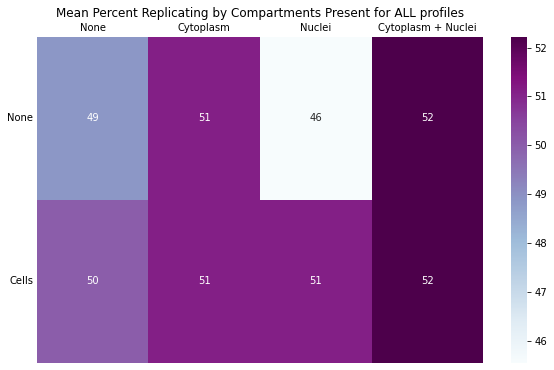

In [45]:
def create_and_graph_heatmap(df,col_list,row_list,cmap,title,figsize,xbreaklen=120,ybreaklen=180,xkcd=False):
    full_col_list = []
    full_col_list_for_labels = []
    full_row_list= []
    full_row_list_for_labels = []
    for eachlen in range(len(col_list)+1):
        full_col_list += sorted([str(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
        full_col_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(col_list,eachlen))])
    for eachlen in range(len(row_list)+1):
        full_row_list += sorted([str(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
        full_row_list_for_labels += sorted([(' + ').join(sorted(x)) for x in list(itertools.combinations(row_list,eachlen))])
    square=pd.DataFrame(columns=full_col_list,index=full_row_list)
    for _,row in df.iterrows():
        sub_rows=[]
        sub_cols=[]
        for thing in row['dropout']:
            if thing not in col_list:
                sub_cols.append(thing)
            else:
                sub_rows.append(thing)
        sub_rows.sort()
        sub_cols.sort()
        # square[str(sub_cols)][str(sub_rows)]=row['percent_replicating']*100
        square.loc[str(sub_cols),str(sub_rows)] = row["percent_replicating"]
    square=square.fillna(0)
    fig, ax = plt.subplots(figsize=figsize)
    fig.set_facecolor("white")
    # if xkcd:
    #     cmap=sns.light_palette(cmap,input='xkcd',as_cmap=True)
    g=sns.heatmap(square,cmap=cmap,annot=True)
    xlabels=['None']
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    for label in full_col_list_for_labels[1:]:
        xlabels.append(textwrap.fill(label, width=xbreaklen/len(full_col_list_for_labels),break_long_words=False))
    g.set_xticklabels(xlabels, rotation=0)
    ylabels=['None']
    for label in full_row_list_for_labels[1:]:
        ylabels.append(textwrap.fill(label, width=ybreaklen/len(full_row_list_for_labels),break_long_words=False))
    g.set_yticklabels(ylabels, rotation=0)
    g.set_title(title)
    plt.savefig(f'figures/{title}.png',dpi=300)
    
    
create_and_graph_heatmap(
    dropout_df,
    col_list=['Nuclei','Cytoplasm'],
    row_list=['Cells'],
    cmap='BuPu',
    title = 'Mean Percent Replicating by Compartments Present for ALL profiles',
    figsize=(10,6))


In [49]:
test = pd.read_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv", usecols=["dropout"])
test

,dropout
0,"('Cytoplasm',)"
1,"('Cytoplasm',)"
2,"('Cells',)"
3,"('Cells',)"
4,"('Nuclei', 'Cells')"
...,...
2935,"('Cells', 'Cytoplasm')"
2936,"('Nuclei', 'Cells')"
2937,"('Nuclei', 'Cells')"
2938,"('Nuclei', 'Cells', 'Cytoplasm')"


In [52]:
test = pd.read_csv("checkpoints/feature-dropouts-nuclei_cytoplasm_cells.csv")
pd.DataFrame(test["dropout"])

,dropout
0,"('Cytoplasm',)"
1,"('Cytoplasm',)"
2,"('Cells',)"
3,"('Cells',)"
4,"('Nuclei', 'Cells')"
...,...
2935,"('Cells', 'Cytoplasm')"
2936,"('Nuclei', 'Cells')"
2937,"('Nuclei', 'Cells')"
2938,"('Nuclei', 'Cells', 'Cytoplasm')"
